[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


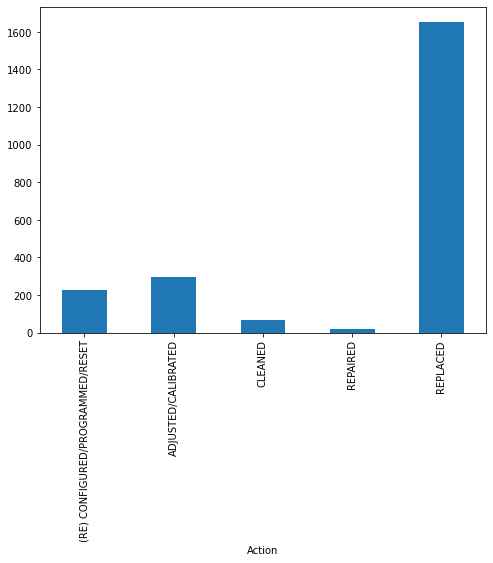

In [93]:
import pandas as pd
import numpy as np
import re
import numpy
import nltk
import string
from io import StringIO
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim import models
import gensim

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams

from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk import punkt

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import pandas.testing as tm
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

from collections import defaultdict
from collections import  Counter
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import preprocessing
from elasticsearch import Elasticsearch
from pandasticsearch import DataFrame


data = pd.read_csv('../file/data_dropna.csv')


nltk.download('stopwords')

stops = set(stopwords.words('english'))


def data_text_cleaning(x):
    only_english = re.sub('[^a-zA-Z]', ' ', x)
    no_capitals = only_english.lower().split()
    stops = set(stopwords.words('english'))
    
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer = nltk.stem.SnowballStemmer('english') #형태소 분석기
    stemmer_words = [stemmer.stem(word) for word in no_stops] #어간 추출
    wordnet_lemmatizer = WordNetLemmatizer() #표제어추출
    words = [wordnet_lemmatizer.lemmatize(w) for w in stemmer_words]
    

    return words

nltk.download('wordnet')
nltk.download('omw-1.4')

data['resolutiontext1'] = data['resolutiontext'].apply(lambda x: data_text_cleaning(x))
data['resolutiontext1'] = data['resolutiontext1'].apply(lambda x: " ".join(str(c) for c in x))

data['servicetext1'] = data['servicetext'].apply(lambda x: data_text_cleaning(str(x)))
data['servicetext1'] = data['servicetext1'].apply(lambda x: " ".join(str(c) for c in x))

data['escalationtext1'] = data['escalationtext'].apply(lambda x: data_text_cleaning(str(x)))
data['escalationtext1'] = data['escalationtext1'].apply(lambda x: " ".join(str(c) for c in x))

data_list = []
data_list.append(data[(data['Action']=='(RE) CONFIGURED/PROGRAMMED/RESET')&
     (data["resolutiontext1"].str.contains("adjust|reset|setup|configur|recov|reboot|initi|pwer|cycl|reimg|firmwar", 
                                          na=False))])
data_list.append(data[(data['Action']=='ADJUSTED/CALIBRATED')&
     (data["resolutiontext1"].str.contains("adjust|level|reteach|calibr|algin|recalibr", 
                                          na=False))])
data_list.append(data[(data['Action']=='CLEANED')&
     (data["resolutiontext1"].str.contains("CLEAN|clean|particl", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPAIRED')&
     (data["resolutiontext1"].str.contains("REPAIR|repair", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPLACED WITH SAME PART')&
     (data["resolutiontext1"].str.contains("replac", 
                                          na=False))])
data_list.append(data[(data['Action']=='REPLACED WITH DIFFERENT PART')&
     (data["resolutiontext1"].str.contains("replac", 
                                          na=False))])
dfs = pd.concat(data_list, axis=0)

dfs.loc[dfs['Action']=='REPLACED WITH SAME PART','Action'] = 'REPLACED'
dfs.loc[dfs['Action']=='REPLACED WITH DIFFERENT PART','Action'] = 'REPLACED'
dfs = dfs.loc[dfs['Action']!='VERIFIED']
dfs = dfs.loc[dfs['Escalation Reason']!='Part Number Needed']


dfs['category_id'] = dfs['Action'].factorize()[0]
category_id_df = dfs[['Action', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)

encoder = LabelEncoder()
encoder.fit(dfs.Action)
dfs['Action_label'] = encoder.transform(dfs.Action)


#dfs check
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

dfs.groupby('Action').resolutiontext.count().plot.bar(ylim=0)
plt.show()






In [104]:
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]

patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    print(text)
    clean = bytes(text.lower(), encoding='utf-8')
    print(clean)
    # return

prepare_for_char_n_gram('Abc')

Abc
b'abc'
